<a href="https://colab.research.google.com/github/puldavid87/anomaly_detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Anomaly detection

## 1.1 Read the dataset

**Local drive:** To upload the file from the local drive write the following code in the cell and run it

In [1]:

from google.colab import files
uploaded = files.upload()

Saving anomaly_detection.csv to anomaly_detection.csv


In [3]:

import pandas as pd
import io
 
df = pd.read_csv(io.BytesIO(uploaded['anomaly_detection.csv']))
print(df)

       CO2   TEMP    HUM  LABEL
0      659  25.83  39.80      1
1      656  25.79  39.98      1
2      655  25.75  39.95      1
3      654  25.85  40.07      1
4      644  25.52  40.22      1
..     ...    ...    ...    ...
568  19070  32.52  37.26      4
569  40000  32.63  37.22      4
570  40000  32.63  37.22      4
571   1942  31.79  36.92      4
572   1942  31.79  36.92      4

[573 rows x 4 columns]


**From GitHub:**  It is the easiest way to upload a CSV file in Colab. For this go to the dataset in your GitHub repository, and then click on “View Raw”. Copy the link to the raw dataset and pass it as a parameter to the read_csv() in pandas to get the dataframe. 

In [ ]:
url = 'https://raw.githubusercontent.com/puldavid87/anomaly_detection/main/anomaly_detection.csv'
df = pd.read_csv(url)
print(df)

       CO2   TEMP    HUM  LABEL
0      659  25.83  39.80      1
1      656  25.79  39.98      1
2      655  25.75  39.95      1
3      654  25.85  40.07      1
4      644  25.52  40.22      1
..     ...    ...    ...    ...
568  19070  32.52  37.26      4
569  40000  32.63  37.22      4
570  40000  32.63  37.22      4
571   1942  31.79  36.92      4
572   1942  31.79  36.92      4

[573 rows x 4 columns]


### 1.1.1 split the dataset into labels

The dataset is devided into labels to deploy outlier detection techniques

In [191]:
label1=df[ (df['LABEL']==1) ]
label2=df[ (df['LABEL']==2) ]
label3=df[ (df['LABEL']==3) ]
label4=df[ (df['LABEL']==4) ]


Also, the dataset is devided in training set and test set for next steps

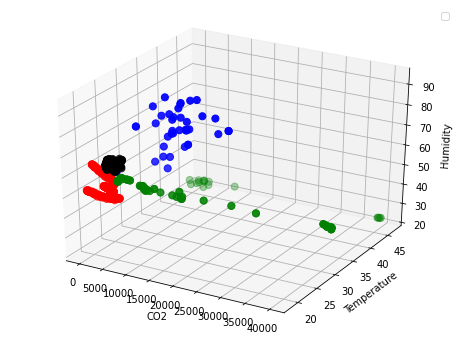

In [190]:
from sklearn.model_selection import train_test_split

X= df.iloc[:,:-1].values
y=df.iloc[:,-1].values

X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=0)
color=df['LABEL']
color=color.replace({1:"red",2:"blue",3:"black",4:"green"})

import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['CO2'],df['TEMP'],df['HUM'],c=df['LABEL'].replace({1:"red",2:"blue",3:"black",4:"green"}),s=50)
ax.legend(loc="best")
ax.set_xlabel("CO2")
ax.set_ylabel("Temperature")
ax.set_zlabel("Humidity")
plt.show()

## 1.2 Noise detection

Errors in the data collection on IoT devices are common due to voltage fluctuations on sensors and unexpected board movements. Therefore, smoothing algorithms reduce the noise. To determine the best algorithm to smooth data, it is necessary to use some statistical metrics related to a different class of errors. In this work, we are going to use signal-to-noise relation, MSE, MAE, RMSE, and R2 score. More information in: https://towardsdatascience.com/comparing-robustness-of-mae-mse-and-rmse-6d69da870828, https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

In [6]:
# Signal to noise metric
import numpy as np

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [7]:
from sklearn import metrics
def timeseries_evaluation_metrics(y_true, y_pred):
   print('Evaluation metric results: ')
   print(f'MSE value : {metrics.mean_squared_error(y_true, y_pred)}')
   print(f'MAE value : {metrics.mean_absolute_error(y_true, y_pred)}')
   print(f'RMSE value : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
   print(f'SNR : {signaltonoise(y_pred)}')
   print(f'R2 score : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 

Several smoothing algorithms should be applied to analog signals. However, the most representative algorithms are Moving average, median, Gaussian, and Savi-Golay. Each algorithm is developed on each analog signal split by labels. 

In [8]:
## CO2 signal smoothing analysis
from scipy.ndimage import gaussian_filter
from scipy import ndimage, misc, signal
import math
size = 5
x = label1["CO2"]
#moving average
y_moving = pd.Series(x.rolling(window =5).mean())
y_moving[0:size]=pd.Series(x[0:size])  
#median
y_med = pd.Series(signal.medfilt(x,size))
#savi-golay
y_vi = pd.Series(signal.savgol_filter(x,5,2))
#gaussian
y_gaussian = pd.Series(gaussian_filter(x, sigma=2))
output = [y_moving,y_med,y_vi,y_gaussian]



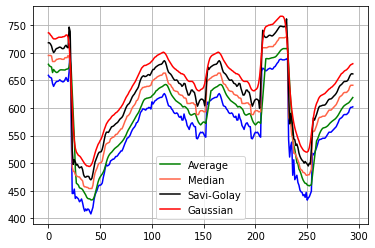

In [9]:
#Ploting the smoothed CO2 signal by different algorithms
plt.plot(x, color="blue")
plt.plot(y_moving+20, color="green", label='Average')
plt.plot(y_med+40, color="tomato", label='Median')
plt.plot(y_vi+60, color="black", label='Savi-Golay')
plt.plot(y_gaussian+80, color= 'red', label='Gaussian')
plt.grid(True)
plt.legend(loc='best')
plt.show()


In [10]:
#Evaluation of smoothed algorithms
for i in output:
    timeseries_evaluation_metrics(x,i)
    print(signaltonoise(i))


Evaluation metric results: 
MSE value : 439.966779661017
MAE value : 9.394576271186441
RMSE value : 20.975385089695422
SNR : 8.136239429638426
R2 score : 0.9133006210165

8.136239429638426
Evaluation metric results: 
MSE value : 31.54915254237288
MAE value : 1.664406779661017
RMSE value : 5.616863229808331
SNR : 7.99772234081448
R2 score : 0.9937829580338159

7.99772234081448
Evaluation metric results: 
MSE value : 34.51824835696992
MAE value : 2.2744794188862283
RMSE value : 5.875223260180835
SNR : 7.977612211932209
R2 score : 0.9931978712155193

7.977612211932209
Evaluation metric results: 
MSE value : 154.2135593220339
MAE value : 5.074576271186441
RMSE value : 12.418275215263748
SNR : 8.269225115389322
R2 score : 0.9696108423586961

8.269225115389322


The gaussian filter has better SNR and R2 metrics combined both. Therefore this algorithm is selected to deploy in the rest of the samples. 

In [11]:
#empty dataframes 
nd1 = pd.DataFrame( columns=["CO2","TEMP","HUM","LABEL"])
nd2 = pd.DataFrame( columns=["CO2","TEMP","HUM","LABEL"])
nd3 = pd.DataFrame( columns=["CO2","TEMP","HUM","LABEL"])
nd4 = pd.DataFrame( columns=["CO2","TEMP","HUM","LABEL"])

In [12]:
#smoothing analog signals with LABEL 1
index_list = label1.columns
data = label1[["CO2","TEMP","HUM"]]
for i in data.columns:
  x=data[i]
  y_gaussian=pd.Series(gaussian_filter(x, sigma=2)) 
  nd1[i]=y_gaussian
nd1["LABEL"]=label1["LABEL"].values 

In [13]:
#smoothing analog signals with LABEL 2
index_list = label2.columns
data = label2[["CO2","TEMP","HUM"]]
for i in data.columns:
  x=data[i]
  y_gaussian=pd.Series(gaussian_filter(x, sigma=2)) 
  nd2[i]=y_gaussian
nd2["LABEL"]=label2["LABEL"].values 

In [14]:
#smoothing analog signals with LABEL 3
index_list = label3.columns
data = label3[["CO2","TEMP","HUM"]]
for i in data.columns:
  x=data[i]
  y_gaussian=pd.Series(gaussian_filter(x, sigma=2)) 
  nd3[i]=y_gaussian
nd3["LABEL"]=label3["LABEL"].values

In [15]:
#smoothing analog signals with LABEL 4
index_list = label4.columns
data = label4[["CO2","TEMP","HUM"]]
for i in data.columns:
  x=data[i]
  y_gaussian=pd.Series(gaussian_filter(x, sigma=2)) 
  nd4[i]=y_gaussian
nd4["LABEL"]=label4["LABEL"].values


In [20]:
#Creating a smoothed dataset
df2=pd.concat([nd1,nd2,nd3,nd4])
print(df2)

      CO2       TEMP        HUM  LABEL
0     656  25.786349  39.935088      1
1     655  25.763746  39.980219      1
2     652  25.714007  40.072484      1
3     650  25.633944  40.212785      1
4     647  25.530006  40.392756      1
..    ...        ...        ...    ...
90  19797  32.434967  37.276137      4
91  21473  32.380756  37.199532      4
92  19861  32.271678  37.123718      4
93  16230  32.144796  37.059302      4
94  13305  32.058996  37.021205      4

[573 rows x 4 columns]


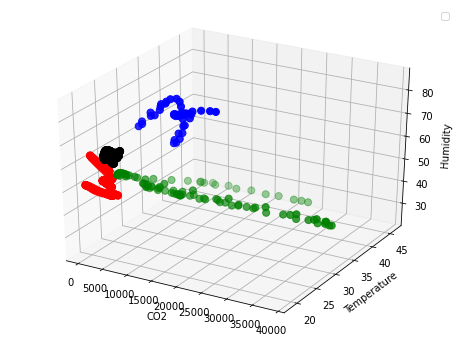

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2['CO2'],df2['TEMP'],df2['HUM'],c=df2['LABEL'].replace({1:"red",2:"blue",3:"black",4:"green"}),s=50)
ax.legend(loc="best")
ax.set_xlabel("CO2")
ax.set_ylabel("Temperature")
ax.set_zlabel("Humidity")
plt.show()

## 1.3 Outlier detection

Outliers are those observations that differ strongly from the rest of the data points and smoothing algorithms can not detect them. Outliers algorithms can be deployed by labels or with the entire dataset. 
 More info in: https://towardsdatascience.com/5-outlier-detection-methods-that-every-data-enthusiast-must-know-f917bf439210 

In [180]:
#ISOLATION FOREST BY LABELS
from sklearn.ensemble import IsolationForest
###label 1
from sklearn.ensemble import IsolationForest
###label 1
iso=IsolationForest(contamination=0.3)
aux=iso.fit_predict(nd1.iloc[:,:-1])
out1=nd1[(aux==1)]
aux=iso.fit_predict(nd2.iloc[:,:-1])
out2=nd2[(aux==1)]
aux=iso.fit_predict(nd3.iloc[:,:-1])
out3=nd3[(aux==1)]
aux=iso.fit_predict(nd4.iloc[:,:-1])
out4=nd4[(aux==1)]
isolation_database=pd.concat([out1,out2,out3,out4])
print(isolation_database)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


      CO2       TEMP        HUM  LABEL
9     647  25.181537  41.045800      1
10    648  25.159775  41.073815      1
11    648  25.142223  41.088854      1
12    648  25.128759  41.096773      1
13    648  25.121000  41.098483      1
..    ...        ...        ...    ...
90  19797  32.434967  37.276137      4
91  21473  32.380756  37.199532      4
92  19861  32.271678  37.123718      4
93  16230  32.144796  37.059302      4
94  13305  32.058996  37.021205      4

[400 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [181]:
# ISOLATION FOREST WITH THE ENTIRE DATASET
iso=IsolationForest(contamination=0.3)
aux=iso.fit_predict(df2.iloc[:,:-1])
isolation_database=df2[(aux==1)]
print(isolation_database)

    CO2       TEMP        HUM  LABEL
0   656  25.786349  39.935088      1
1   655  25.763746  39.980219      1
2   652  25.714007  40.072484      1
3   650  25.633944  40.212785      1
4   647  25.530006  40.392756      1
..  ...        ...        ...    ...
23  613  26.206175  49.318860      4
24  552  26.486389  49.107516      4
25  514  26.769926  48.790329      4
26  489  27.059049  48.369042      4
27  459  27.360906  47.866537      4

[401 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [183]:
#ISOLATION FOREST BY LABELS
from sklearn.covariance import EllipticEnvelope
ee = EllipticEnvelope(contamination=0.3)
aux = ee.fit_predict(nd1.iloc[:,:-1])
out1 = nd1[(aux==1)]
aux = ee.fit_predict(nd2.iloc[:,:-1])
out2 = nd2[(aux==1)]
aux = ee.fit_predict(nd3.iloc[:,:-1])
out3 = nd3[(aux==1)]
aux = ee.fit_predict(nd4.iloc[:,:-1])
out4 = nd4[(aux==1)]
elliptic_database=pd.concat([out1,out2,out3,out4])
print(elliptic_database)

      CO2       TEMP        HUM  LABEL
0     656  25.786349  39.935088      1
1     655  25.763746  39.980219      1
2     652  25.714007  40.072484      1
3     650  25.633944  40.212785      1
4     647  25.530006  40.392756      1
..    ...        ...        ...    ...
90  19797  32.434967  37.276137      4
91  21473  32.380756  37.199532      4
92  19861  32.271678  37.123718      4
93  16230  32.144796  37.059302      4
94  13305  32.058996  37.021205      4

[400 rows x 4 columns]


In [184]:
#ISOLATION FOREST WITH THE ENTIRE DATASET
ee = EllipticEnvelope(contamination=0.3)
aux=ee.fit_predict(df2.iloc[:,:-1])
elliptic_database=df2[(aux==1)]
print(elliptic_database)

     CO2       TEMP        HUM  LABEL
0    656  25.786349  39.935088      1
1    655  25.763746  39.980219      1
2    652  25.714007  40.072484      1
3    650  25.633944  40.212785      1
4    647  25.530006  40.392756      1
..   ...        ...        ...    ...
32  1453  28.908369  45.108507      4
52  1129  32.129444  37.650713      4
82  1199  31.900124  36.919344      4
83  1053  31.979764  37.018438      4
84  1318  32.074994  37.136356      4

[401 rows x 4 columns]


In [185]:
#ONE CLASS SVM
from sklearn.svm import OneClassSVM
osvm = OneClassSVM(kernel='poly', nu=0.3)
aux=osvm.fit_predict(df2.iloc[:,:-1])
one_svm_database=df2[(aux==1)]
print(one_svm_database)

      CO2       TEMP        HUM  LABEL
0     656  25.786349  39.935088      1
1     655  25.763746  39.980219      1
2     652  25.714007  40.072484      1
3     650  25.633944  40.212785      1
4     647  25.530006  40.392756      1
..    ...        ...        ...    ...
90  19797  32.434967  37.276137      4
91  21473  32.380756  37.199532      4
92  19861  32.271678  37.123718      4
93  16230  32.144796  37.059302      4
94  13305  32.058996  37.021205      4

[352 rows x 4 columns]


In [186]:
# OUTLIER FACTOR
from sklearn.neighbors import LocalOutlierFactor

local = LocalOutlierFactor(contamination=0.3)
aux = local.fit_predict(df2.iloc[:,:-1])
local_database=df2[(aux==1)]
print(local_database)

      CO2       TEMP        HUM  LABEL
0     656  25.786349  39.935088      1
1     655  25.763746  39.980219      1
2     652  25.714007  40.072484      1
3     650  25.633944  40.212785      1
4     647  25.530006  40.392756      1
..    ...        ...        ...    ...
66  13042  32.036563  37.380818      4
78  12088  32.060081  36.684492      4
79   6946  31.946480  36.734405      4
82   1199  31.900124  36.919344      4
85   2094  32.169154  37.255227      4

[401 rows x 4 columns]


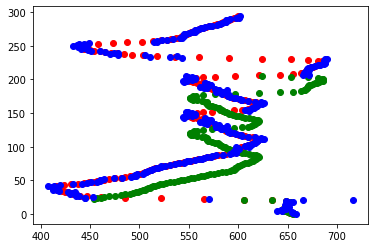

In [187]:
#EXAMPLE WITH ORGINAL SAMPLES (RED), SMOOTHED SAMPLES (BLUE), AND CLEANED SAMPLES (GREEN)
plt.scatter(nd1["CO2"], np.arange(len(nd1["CO2"])), color='r')
plt.scatter(out1["CO2"], np.arange(len(out1["CO2"])), color='g')
plt.scatter(label1["CO2"], np.arange(len(label1["CO2"])), color='b')
plt.show()

## 1.4 Tamper detection

Tamper detection is the ability of a device to sense that an active attempt to compromise the device integrity or the data associated with the device is in progress; the detection of the threat may enable the device to initiate appropriate defensive actions. More information in: https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-5906-5_229

It is important to remember that the proposed system has four labels, and two of them are tamper options. Therefore, with the refined dataset obtained from the previous section, the multi-class classification would be improved. Thus, the classification algorithms and deep learning techniques are trained with the original samples. Then, they are trained with the refined dataset to demonstrate the outlier detection phase. More information in classification metrics in: https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5

### 1.4.1 Orginal samples

#### Classification algorithms

In [144]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


classifier=SVC(kernel='sigmoid', random_state=0)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.72      1.00      0.83        53
           2       0.50      1.00      0.67         8
           3       0.41      0.22      0.29        32
           4       0.25      0.09      0.13        22

    accuracy                           0.61       115
   macro avg       0.47      0.58      0.48       115
weighted avg       0.53      0.61      0.54       115

[[53  0  0  0]
 [ 0  8  0  0]
 [16  3  7  6]
 [ 5  5 10  2]]


In [145]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98        53
           2       0.73      1.00      0.84         8
           3       1.00      0.97      0.98        32
           4       1.00      1.00      1.00        22

    accuracy                           0.97       115
   macro avg       0.93      0.98      0.95       115
weighted avg       0.98      0.97      0.98       115

[[51  2  0  0]
 [ 0  8  0  0]
 [ 0  1 31  0]
 [ 0  0  0 22]]


In [146]:
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(1)
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97        53
           2       0.88      0.88      0.88         8
           3       0.81      0.91      0.85        32
           4       0.94      0.73      0.82        22

    accuracy                           0.90       115
   macro avg       0.90      0.87      0.88       115
weighted avg       0.91      0.90      0.90       115

[[52  0  1  0]
 [ 0  7  0  1]
 [ 2  1 29  0]
 [ 0  0  6 16]]


In [147]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           1       0.83      1.00      0.91        53
           2       0.88      0.88      0.88         8
           3       0.69      0.75      0.72        32
           4       1.00      0.36      0.53        22

    accuracy                           0.80       115
   macro avg       0.85      0.75      0.76       115
weighted avg       0.82      0.80      0.78       115

[[53  0  0  0]
 [ 0  7  1  0]
 [ 8  0 24  0]
 [ 3  1 10  8]]


#### deep learning

In [159]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

encoder = OneHotEncoder(sparse=False)
y_nn=pd.DataFrame(y)
y_nn = encoder.fit_transform(y_nn)
sc=MinMaxScaler()
X_nn=sc.fit_transform(X)
X_train_nn, X_test_nn,y_train_nn,y_test_nn=train_test_split(X_nn,y_nn,test_size=0.2, random_state=0)
print(y_nn)








[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [171]:
model = Sequential()

model.add(Dense(6, input_shape=(3,), activation='relu', name='fc1'))
model.add(Dense(24, activation='relu', name='fc2'))
model.add(Dense(8, activation='relu', name='fc3'))
model.add(Dense(4, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])


history=model.fit(X_train_nn, y_train_nn, validation_split=0.33, batch_size=5, epochs=20)

Epoch 1/20
38/38 [==============================] - 1s 7ms/step - loss: 1.4285 - accuracy: 0.2074 - val_loss: 1.3595 - val_accuracy: 0.3226
Epoch 2/20
38/38 [==============================] - 0s 4ms/step - loss: 1.3416 - accuracy: 0.3723 - val_loss: 1.3164 - val_accuracy: 0.5914
Epoch 3/20
38/38 [==============================] - 0s 3ms/step - loss: 1.3052 - accuracy: 0.5798 - val_loss: 1.2797 - val_accuracy: 0.6344
Epoch 4/20
38/38 [==============================] - 0s 3ms/step - loss: 1.2630 - accuracy: 0.6543 - val_loss: 1.2366 - val_accuracy: 0.7312
Epoch 5/20
38/38 [==============================] - 0s 4ms/step - loss: 1.2109 - accuracy: 0.7340 - val_loss: 1.1833 - val_accuracy: 0.7312
Epoch 6/20
38/38 [==============================] - 0s 4ms/step - loss: 1.1465 - accuracy: 0.7340 - val_loss: 1.1191 - val_accuracy: 0.7312
Epoch 7/20
38/38 [==============================] - 0s 3ms/step - loss: 1.0644 - accuracy: 0.7394 - val_loss: 1.0377 - val_accuracy: 0.7204
Epoch 8/20
38/38 [==

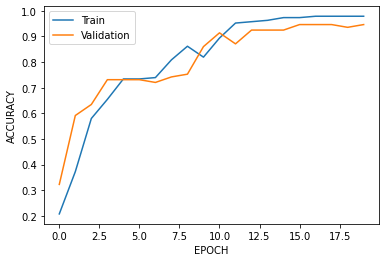

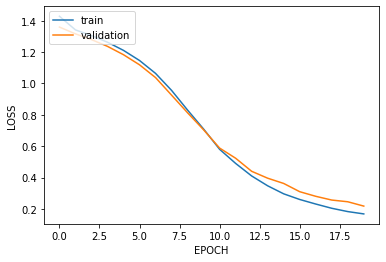

In [172]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('ACCURACY',fontname="Times New Roman")
plt.xlabel('EPOCH',fontname="Times New Roman")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS',fontname="Times New Roman")
plt.xlabel('EPOCH',fontname="Times New Roman")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [173]:

y_pred = model.predict(X_test_nn)
y_pred = (y_pred > 0.5)
index=np.argmax(y_pred)
index
from sklearn import metrics
print("")
print("Precision: {}%".format(100*metrics.precision_score(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1), average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1), average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1), average="weighted")))
print("Error_absoluto: {}%".format(metrics.mean_absolute_error(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1))))
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
report=classification_report(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1))
print('\nReporte\n')
print(report)


Precision: 98.63422962014512%
Recall: 98.59154929577466%
f1_score: 98.57176503839088%
Error_absoluto: 0.014084507042253521%

Reporte

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        12
           2       0.97      1.00      0.98        32
           3       1.00      1.00      1.00         8

    accuracy                           0.99        71
   macro avg       0.99      0.98      0.99        71
weighted avg       0.99      0.99      0.99        71



### 1.4.2 Improved samples

Classification algorithms and deep learning models are trained with the refined dataset obtained by one class SVM since this algorithm pruned more samples. 

#### Classic algorithms

In [175]:
X= one_svm_database.iloc[:,:-1].values
y=one_svm_database.iloc[:,-1].values

X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=0)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


classifier=SVC(kernel='linear', random_state=0)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

#### Deep learning

In [176]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

encoder = OneHotEncoder(sparse=False)
y_nn=pd.DataFrame(y)
y_nn = encoder.fit_transform(y_nn)
sc=MinMaxScaler()
X_nn=sc.fit_transform(X)
X_train_nn, X_test_nn,y_train_nn,y_test_nn=train_test_split(X_nn,y_nn,test_size=0.2, random_state=0)
print(y_nn)


[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [177]:
model = Sequential()

model.add(Dense(4, input_shape=(3,), activation='relu', name='fc1'))
model.add(Dense(24, activation='relu', name='fc2'))
model.add(Dense(8, activation='relu', name='fc3'))
model.add(Dense(4, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])


history=model.fit(X_train_nn, y_train_nn, validation_split=0.33, batch_size=5, epochs=20)

Epoch 1/20
38/38 [==============================] - 1s 8ms/step - loss: 1.4051 - accuracy: 0.1011 - val_loss: 1.3812 - val_accuracy: 0.2366
Epoch 2/20
38/38 [==============================] - 0s 5ms/step - loss: 1.3580 - accuracy: 0.2287 - val_loss: 1.3431 - val_accuracy: 0.4409
Epoch 3/20
38/38 [==============================] - 0s 4ms/step - loss: 1.3098 - accuracy: 0.6489 - val_loss: 1.2849 - val_accuracy: 0.6237
Epoch 4/20
38/38 [==============================] - 0s 4ms/step - loss: 1.2313 - accuracy: 0.6489 - val_loss: 1.2280 - val_accuracy: 0.6559
Epoch 5/20
38/38 [==============================] - 0s 3ms/step - loss: 1.1692 - accuracy: 0.6543 - val_loss: 1.1804 - val_accuracy: 0.6237
Epoch 6/20
38/38 [==============================] - 0s 3ms/step - loss: 1.1198 - accuracy: 0.6543 - val_loss: 1.1438 - val_accuracy: 0.6237
Epoch 7/20
38/38 [==============================] - 0s 4ms/step - loss: 1.0831 - accuracy: 0.6543 - val_loss: 1.1160 - val_accuracy: 0.6237
Epoch 8/20
38/38 [==

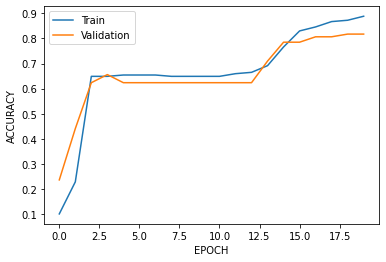

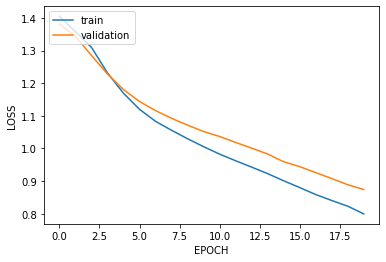

In [178]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('ACCURACY',fontname="Times New Roman")
plt.xlabel('EPOCH',fontname="Times New Roman")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS',fontname="Times New Roman")
plt.xlabel('EPOCH',fontname="Times New Roman")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [179]:
#Reporte de evaluación del modelo
#Predecir los resultados del conjunto de prueba
y_pred = model.predict(X_test_nn)
y_pred = (y_pred > 0.5)
#print(y_pred)
index=np.argmax(y_pred)
index
from sklearn import metrics
print("")
print("Precision: {}%".format(100*metrics.precision_score(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1), average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1), average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1), average="weighted")))
print("Error_absoluto: {}%".format(metrics.mean_absolute_error(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1))))
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
report=classification_report(np.array(y_test_nn).argmax(axis=1),y_pred.argmax(axis=1))
print('\nReporte\n')
print(report)


Precision: 19.33825173261793%
Recall: 38.028169014084504%
f1_score: 23.668842322226038%
Error_absoluto: 1.0704225352112675%

Reporte

              precision    recall  f1-score   support

           0       0.30      1.00      0.46        19
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        32
           3       1.00      1.00      1.00         8

    accuracy                           0.38        71
   macro avg       0.33      0.50      0.37        71
weighted avg       0.19      0.38      0.24        71



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

## 1.5 Exporting models

The decision tree has the better classification metrics, one-class SVM prunes outliers adequately, and the neural network has similar results using original and improved samples.

### Outlier detection


In [188]:
#pip install m2cgen


In [143]:
from sklearn.svm import OneClassSVM
import m2cgen as m2c

osvm = OneClassSVM(kernel='sigmoid', nu=0.3)
osvm.fit(X,y)
code=m2c.export_to_python(osvm)
with open('osvm.py', 'w') as file:
    file.write(code)
print(code)

code2=m2c.export_to_c_sharp(osvm)
with open('osvm.h', 'w') as file:
    file.write(code2)

import math
def score(input):
    var0 = -0.6656266842393999 + math.tanh(0.000000014257154212318266 * (571.0 * input[0] + 22.86 * input[1] + 43.45 * input[2]) + 0.0) * 1.0 + math.tanh(0.000000014257154212318266 * (445.0 * input[0] + 22.16 * input[1] + 44.95 * input[2]) + 0.0) * 1.0 + math.tanh(0.000000014257154212318266 * (445.0 * input[0] + 21.57 * input[1] + 45.98 * input[2]) + 0.0) * 1.0 + math.tanh(0.000000014257154212318266 * (453.0 * input[0] + 20.83 * input[1] + 47.2 * input[2]) + 0.0) * 1.0 + math.tanh(0.000000014257154212318266 * (436.0 * input[0] + 20.22 * input[1] + 48.93 * input[2]) + 0.0) * 1.0 + math.tanh(0.000000014257154212318266 * (439.0 * input[0] + 20.06 * input[1] + 49.39 * input[2]) + 0.0) * 1.0 + math.tanh(0.000000014257154212318266 * (437.0 * input[0] + 19.81 * input[1] + 50.31 * input[2]) + 0.0) * 1.0
    var1 = math.tanh(0.000000014257154212318266 * (435.0 * input[0] + 19.81 * input[1] + 50.4 * input[2]) + 0.0) * 1.0
    var2 = var0 + var1 + math.tanh(0.0000000

### Classification algorithms

In [157]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
code=m2c.export_to_python(clf)
with open('dtc2.py', 'w') as file:
    file.write(code)
print(code)

code2=m2c.export_to_c_sharp(clf)
with open('dtc2.h', 'w') as file:
    file.write(code2)

def score(input):
    if input[2] <= 53.05961990356445:
        if input[0] <= 687.5:
            if input[1] <= 25.996261596679688:
                var0 = [1.0, 0.0, 0.0, 0.0]
            else:
                var0 = [0.0, 0.0, 0.0, 1.0]
        else:
            var0 = [0.0, 0.0, 0.0, 1.0]
    else:
        if input[0] <= 3821.0:
            var0 = [0.0, 0.0, 1.0, 0.0]
        else:
            var0 = [0.0, 1.0, 0.0, 0.0]
    return var0



### Deep Learning

In [174]:
for layerNum, layer in enumerate(model.layers):
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
    
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} \
                  -> L{layerNum+1}N{toNeuronNum} = {wgt2}')

0B -> L1N0: -0.047450002282857895
0B -> L1N1: 0.33749455213546753
0B -> L1N2: 0.0
0B -> L1N3: 0.0
0B -> L1N4: 0.20100131630897522
0B -> L1N5: -0.05993330106139183
L0N0                   -> L1N0 = 0.9717501997947693
L0N0                   -> L1N1 = 0.3264310956001282
L0N0                   -> L1N2 = -0.5963156819343567
L0N0                   -> L1N3 = -0.5705291628837585
L0N0                   -> L1N4 = -0.41238903999328613
L0N0                   -> L1N5 = 1.268875002861023
L0N1                   -> L1N0 = 0.8214201927185059
L0N1                   -> L1N1 = 0.6122007369995117
L0N1                   -> L1N2 = -0.7753572463989258
L0N1                   -> L1N3 = -0.7957298159599304
L0N1                   -> L1N4 = -0.7507667541503906
L0N1                   -> L1N5 = 0.409166157245636
L0N2                   -> L1N0 = 0.928337574005127
L0N2                   -> L1N1 = -0.5886215567588806
L0N2                   -> L1N2 = -0.6889365315437317
L0N2                   -> L1N3 = -0.320982933044433